# Spam detection using text clustering
The following notebook will attempt to implement the algorithm explained in the paper: 
M. Sasaki and H. Shinnou, "Spam detection using text clustering," 2005 International Conference on Cyberworlds (CW'05), 2005, pp. 4 pp.-319, doi: 10.1109/CW.2005.83.


## Method
The corpus is vectorised using TF-IDF. Subsequently, a spherical K-means clustering is computed with K=2. Hence, obtaining two centroids. Once the centroids have been determined each centroid is classified as either spam or non-spam using a majority vote approach of the documents' classes. The reason that the spherical K-means is utilised is the same reason that cosine similarity typically is used to determine similarity between vectorized documents. The consequence of this approach is that document representations only differ in magnitude and not in angle, given that all vectors are normalized to 1.

### Spherical K-means (SKM)

1) Connect vectors tails at origin

2) Project onto unit sphere (Accounts for heterogenous document length)

3) Use clustering to minimize cosine dissimilarity:
$$ J = \sum_{i} d(x_{i}, P_{c(i)})$$
$$d(x_{i}, P_{c(i)} = 1- cos(x_{i}, P_{c(i)})=\frac{\langle x_{i},P_{c(i)}}{||x_{i}||\cdot||P_{c(i)}||}$$



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import nltk

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return None
setup_mpl()

In [3]:
import random
import scipy.spatial.distance
from scipy.special import softmax
from scipy.spatial.distance import cdist

def plus_plus(X, k, random_state=42):
    '''
    ##########################
    #k-means++ initialization#
    ##########################
    
    The approach:
         * 1st centroid is chosen uniformly at random from the observations.
         * Subsequently, the remaining centroids are chosen from the remaining observation with probability
           proportionally with the squared distance to the closest existing centroid
    
    Parameters:
        * X : Observations, X \in R^{observations x features}
        * k : Number of centroids
    
    by Christian Djurhuus
    '''
    np.random.seed(random_state)
    
    # Allocating memory
    centroids = np.zeros((k, X.shape[1]))
    
    # Sampling first centroid uniformly at random from observations
    indicies = [i for i in range(X.shape[0])]
    first_idx = np.random.choice(indicies, size=1)
    indicies.remove(first_idx)
    centroids[0,:] = X[first_idx, :]

    # Determining remaining number of centroids:
    for i in range(1,k):
        print(f'Number of centroids defined: {i+1}')
        # Compute distance between all observations and existing centroids
        pair_dist = (((np.expand_dims(X[indicies,:], 1)-centroids[:i,:]+1e-06)**2).sum(-1))
        #pair_dist = cdist(X[indicies,:], centroids[:i,:], metric='euclidean')

        # Probabilities:
        if pair_dist.ndim==1:
            #only one centroid available. Hence, dist to nearest centroid is just pair dist
            dist = pair_dist
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()
        else:
            dist = pair_dist.min(axis=1)
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()


        #Selecting one of the remaining observations
        selected_idx = np.random.choice(indicies,size=1, p=probs)
        indicies.remove(selected_idx)
        centroids[i, :] = X[selected_idx, :]
    
    return centroids

In [4]:
#Testing initializatin method
#plus_plus(X,k=10)

In [4]:
def SKM(X, K, tot=1e-4, random_state=42):
    '''
    ################################
    # Spherical K-means clustering #
    ################################
    
    Parameters:
        X = Data
        tol = Tolerence parameter in stopping criteria
    
    Important property of euclidean and cosine distance, when a & b is normalized
    ||a - b|| = 2(1 - cos(a,b))
    
    by Christian Djurhuus
    '''
    
    #computing initial centroids
    centroids = plus_plus(X=X, k=K, random_state=random_state)
    prev_centroids = np.zeros((centroids.shape[0], centroids.shape[1]))
    diff = 1e5
    #Allocating memory for distances
    dist = np.zeros((X.shape[0], X.shape[1]))
    
    #Conducting SMK
    itr = 1
    while diff > tot: #Stopping criteria
        print(f'Iteration number: {itr} - diff {diff}')
        prev_centroids = centroids.copy()
        prev_diff = diff
        
        dists = ((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5 #Using broadcasting to compute dists
        assignments = dists.argmin(axis=1)
        
        #Update centroid position
        for idx in range(K):
            centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)
        
        #l2 normalisation of centroids, this is the main difference from traditional K-means
        #centroids = centroids / (np.sqrt(np.sum(centroids**2)) + 1e-6)
        centroids = normalize(centroids)
        itr += 1
        
        #Distance between previous centroids and current
        diff = ((((prev_centroids - centroids + 1e-6)**2).sum(-1))**0.5).sum()
        
        #Early stopping when converged
        #if diff == prev_diff:
        #    break
        if diff < tot or diff == prev_diff:
            break
        
    return assignments, centroids


def kmeans(X, k, random_state=42, tot=1e-4, n_init=10):


    #Substracting mean of data
    X -= X.mean(axis=0)

    best_inertia = 1e6

    #run n_init number of the kmeans algorithm and return clusters with minimum inertia
    for i in range(1, n_init+1):
        print(f'Kmeans run no. {i}')
        
        #Determining centroids using kmeans++
        centroids = plus_plus(X=X, k=k, random_state=i*random_state)

        #initial placeholder
        prev_centroids = np.zeros(centroids.shape)
        assignments = np.zeros(X.shape[0])

        #Run until convergence
        itr = 1
        diff = 1e5
        while not np.allclose(prev_centroids, centroids):
            print(f'Iteration number: {itr} - diff {diff}')
            prev_diff = diff
            prev_assignments = assignments

            #Using broadcasting to compute pairwise distances between observations and centroids
            dists=((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5
            assignments = dists.argmin(axis=1)
            prev_centroids = centroids.copy()

            #Update centroid position
            for idx in range(k):
                centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)

            itr += 1


            #Distance between previous centroids and current
            diff = ((((prev_centroids - centroids + 1e-6)**2).sum(-1))**0.5).sum()

            #Early stopping when converged
            if np.array_equal(prev_assignments, assignments): #Check for strict convergence
                break

            if diff < tot: #Check for loose convergence
                break

        #Computing inertia
        #Sum of squared distance between each sample and its assigned center.
        #TODO: use broadcasting instead of for loop
        inertia = 0
        for idx in range(k):
            #inertia_dist = X[np.where(assignments==idx)] - centroids[idx, :]
            #inertia += (inertia_dist.T@inertia_dist).sum()
            inertia += np.sum((np.expand_dims(X[np.where(assignments==idx)],1) - centroids[idx, :]) ** 2, axis=0).sum() #squared dist
            #inertia += np.linalg.norm(X[np.where(assignments==idx)] - centroids[idx, :])**2

        if inertia < best_inertia:
            best_inertia = inertia
            print(f'Current best inertia: {best_inertia}')
            best_assignments = assignments
            best_centroids = centroids

    return best_assignments, best_centroids


In [6]:
def centroid_classification(df, centroids):
    '''
    Majority vote classification
    '''

    return

In [108]:
from sklearn import metrics

def performance_metrics(X, assign, labels):
    print(f'ARI: {metrics.adjusted_rand_score(labels, assign):.3f}')
    print(f'NMI: {metrics.adjusted_mutual_info_score(labels, assign):.3f}')
    print(f'DBI: {metrics.davies_bouldin_score(X, assign):.3f}')
    print('\n')
    return None

In [6]:
from ast import literal_eval
df = pd.read_csv('CleanData/clean_spam.csv')
df['tokens'] = df['tokens'].apply(literal_eval)
df.head()

,text,label,tokens,str_tokens
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam,"[save, life, insur, spend, life, quot, save, e...",save life insur spend life quot save ensur fam...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...
3,##############################################...,spam,"[adult, club, offer, free, membership, instant...",adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,spam,"[thought, might, like, slim, guarante, lose, l...",thought might like slim guarante lose lb day u...


In [109]:
#TDIDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def identity_tokenizer(text):
    return text

#vectorizer = TfidfVectorizer(analyzer='word',
#    tokenizer=identity_tokenizer,
#    preprocessor=identity_tokenizer,
#    token_pattern=None)

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

In [110]:
X.shape

(5572, 5756)

In [111]:
#assign_smk, centroids_skm = SKM(X.todense(), K=2, random_state=1984)
#yield the best result seed = 2
assign_kmeans, centroids_kmeans = kmeans(X.todense(), k=2, random_state=2, tot=0.0001)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.9535712371843759
Iteration number: 3 - diff 0.04372178335085862
Iteration number: 4 - diff 0.00945944030874744
Iteration number: 5 - diff 0.002684195775963822
Current best inertia: 5477.451103919042
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.807722899012472
Iteration number: 3 - diff 0.06450836861381835
Iteration number: 4 - diff 0.060622587484400796
Iteration number: 5 - diff 0.06521371950505699
Iteration number: 6 - diff 0.08200620013302003
Iteration number: 7 - diff 0.06373981490392132
Iteration number: 8 - diff 0.03854832166581814
Iteration number: 9 - diff 0.03298495068085701
Iteration number: 10 - diff 0.031317206271359796
Iteration number: 11 - diff 0.017209098963100702
Iteration number: 12 - diff 0.010235306381368258
Iteration number: 13 - diff 0.010721362514936102
Iteration number: 14 - diff 0.013

In [112]:
from sklearn.cluster import DBSCAN, KMeans

clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X)
assign_db = clustering_db.labels_

In [114]:
labels = df['label'].replace({'ham':0, 'spam':1}).values

In [116]:
performance_metrics(X.toarray(), assign_kmeans, labels)
performance_metrics(X.toarray(), assign_db, labels)

ARI: 0.352
NMI: 0.177
DBI: 6.265


ARI: 0.235
NMI: 0.125
DBI: 1.054




We might be suffering from the curse of dimensionality, let us try to conduct dimensionality reduction and then perform clustering:

In [15]:
from sklearn.cluster import DBSCAN, KMeans

clustering_db = DBSCAN(eps=1, min_samples=20).fit(X)

clustering_km = KMeans(n_clusters=2).fit(X)

print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)), clustering_db.labels_))
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)), clustering_km.labels_))


0.0008376728837928992
0.36448308902566684


In [16]:
clustering_km.inertia_

5457.92188508485

In [17]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [18]:
X_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=70, verbose=False).fit_transform(X)

In [19]:
#X_umap = umap.UMAP(n_components=30, metric='hellinger', n_neighbors=50, min_dist=0.6).fit_transform(X)
X_umap = umap.UMAP(metric='cosine').fit_transform(X)
#X_umap = umap.UMAP(metric='hellinger').fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2259 edges.
It has only fully disconnected 85 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


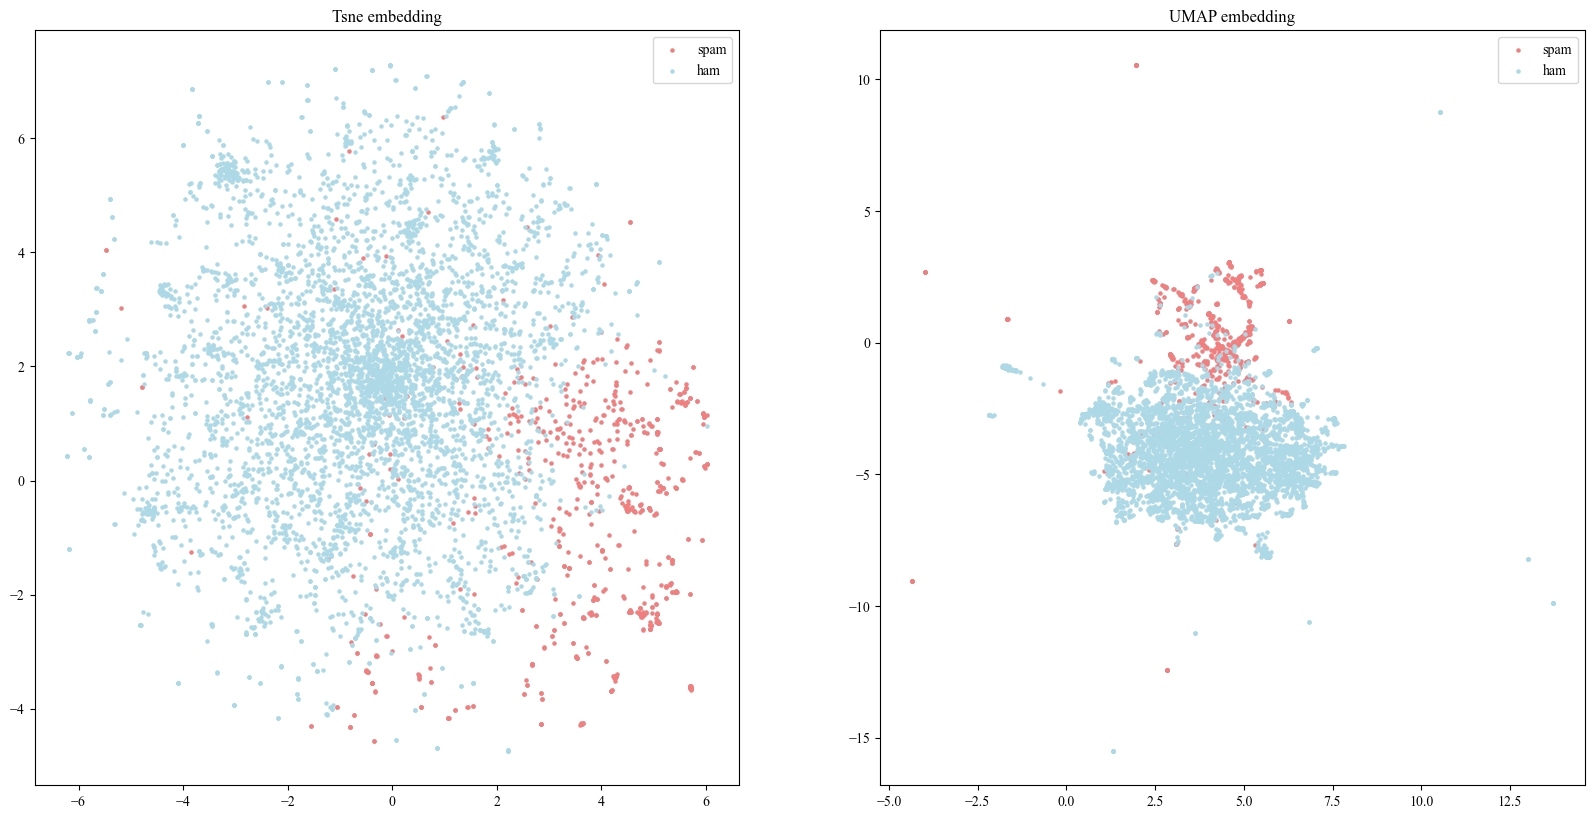

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)
spam_idx = df['label']=='spam'
ham_idx = df['label']=='ham'
ax1.scatter(X_tsne.T[0,:][spam_idx], X_tsne.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax1.scatter(X_tsne.T[0,:][ham_idx], X_tsne.T[1,:][ham_idx], c='lightblue',s=5, label='ham')
ax1.set_title('Tsne embedding')
ax1.legend()

ax2.scatter(X_umap.T[0,:][spam_idx], X_umap.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax2.scatter(X_umap.T[0,:][ham_idx], X_umap.T[1,:][ham_idx], c='lightblue',s=5, label='ham')
ax2.set_title('UMAP embedding')
ax2.legend()

plt.show()

In [21]:
#Umap for downstream tasks (dim=30 works well)
X_umap_dt = umap.UMAP(metric='cosine', n_components=10).fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2272 edges.
It has only fully disconnected 85 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [27]:
#UMAP unfortunately produces a few NaN values
NaN_idx = np.argwhere(np.isnan(X_umap_dt))
X_temp_dt = X_umap_dt[~np.isnan(X_umap_dt).any(axis=1)]
assign, centroids = kmeans(X_temp_dt, k=2, random_state=2, tot=1e-4)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.4848880085346656
Current best inertia: 28507.88457708903
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.523534369921955
Iteration number: 3 - diff 0.7224170206089743
Iteration number: 4 - diff 0.3441135538083449
Iteration number: 5 - diff 0.1897821213818591
Iteration number: 6 - diff 0.09175136184119707
Iteration number: 7 - diff 0.0454329152371101
Iteration number: 8 - diff 0.023117461377898003
Iteration number: 9 - diff 0.00972918521905388
Iteration number: 10 - diff 0.00966110730954298
Current best inertia: 26129.76415715819
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.1384266437431427
Iteration number: 3 - diff 1.088608562278169
Iteration number: 4 - diff 0.8620339209303776
Iteration number: 5 - diff 0.4638534851910823
Iteration number: 6 

In [28]:
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)).drop(np.unique(NaN_idx[:,0])), assign))

0.7368648486337479


In [29]:
clustering = KMeans(n_clusters=2).fit(X_temp_dt)
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)).drop(np.unique(NaN_idx[:,0])), clustering.labels_))

0.7368648486337479


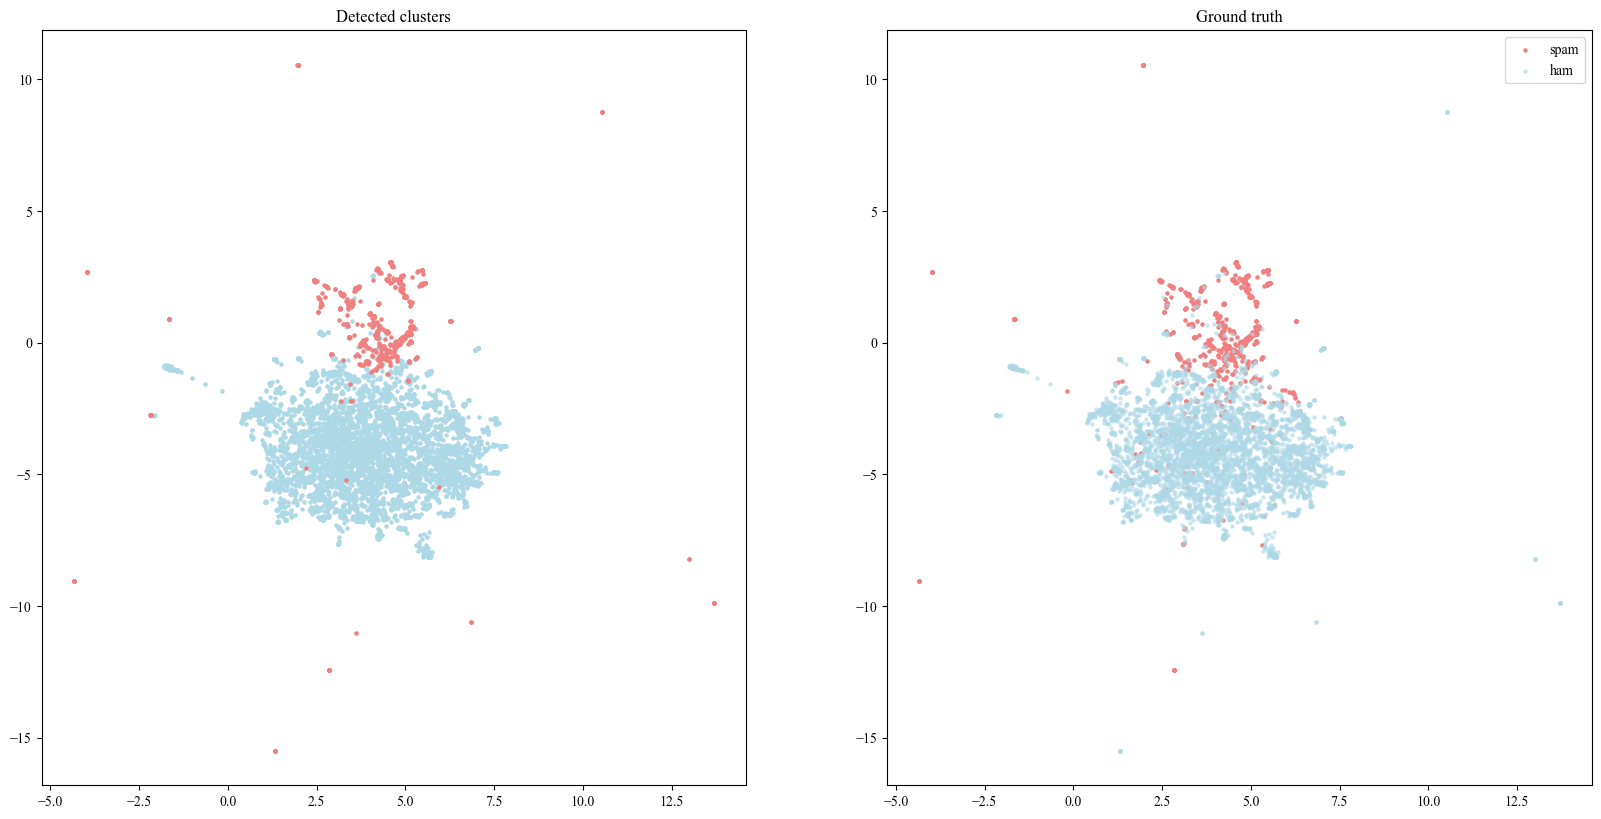

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)

clust_1 = np.where(assign==0)
clust_2 = np.where(assign==1)

ax1.scatter(X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[0,:][clust_1], X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[1,:][clust_1], c='lightblue',s=5)
ax1.scatter(X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[0,:][clust_2], X_umap[~np.isnan(X_umap_dt).any(axis=1)].T[1,:][clust_2], c='lightcoral',s=5)
ax1.set_title('Detected clusters')
#ax1.legend()

ax2.scatter(X_umap.T[0,:][spam_idx], X_umap.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax2.scatter(X_umap.T[0,:][ham_idx], X_umap.T[1,:][ham_idx], c='lightblue',s=5, label='ham', alpha=0.5)
ax2.set_title('Ground truth')
ax2.legend()

plt.show()

In [23]:
from sklearn.decomposition import PCA
pca = PCA().fit(X.todense().T)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


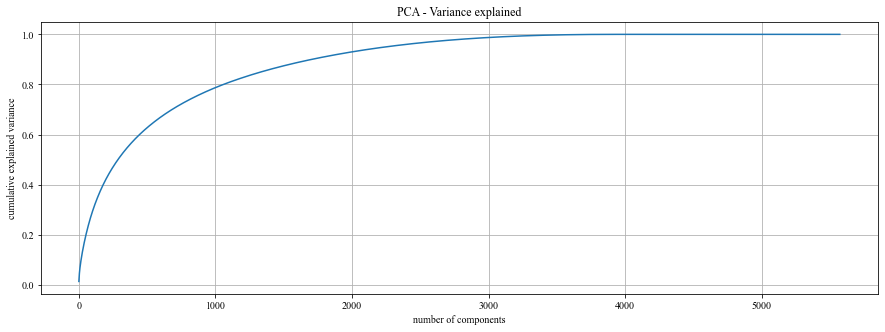

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')
ax.set_title('PCA - Variance explained')
ax.grid()
plt.show()

In [242]:
#pca = PCA(0.80).fit(X.todense().T)
#pca_embedding = pca.components_.T

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000).fit(X.todense().T)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [38]:
pca_embedding = pca.components_.T
pca_embedding.shape

(5572, 1000)

In [39]:
assign, centroids = kmeans(pca_embedding, k=2, random_state=42, tot=0.0001, n_init=1)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 0.5837056927106653
Iteration number: 3 - diff 0.05266247909596457
Iteration number: 4 - diff 0.029762728679344704
Current best inertia: 998.2927079739159


In [40]:
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)), assign))

-0.005164222202397779


In [41]:
clustering = KMeans(n_clusters=2).fit(pca_embedding)
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)), clustering.labels_))

0.0011258966718986048


In [42]:
np.unique(assign, return_counts=True)

(array([0, 1]), array([5547,   25]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


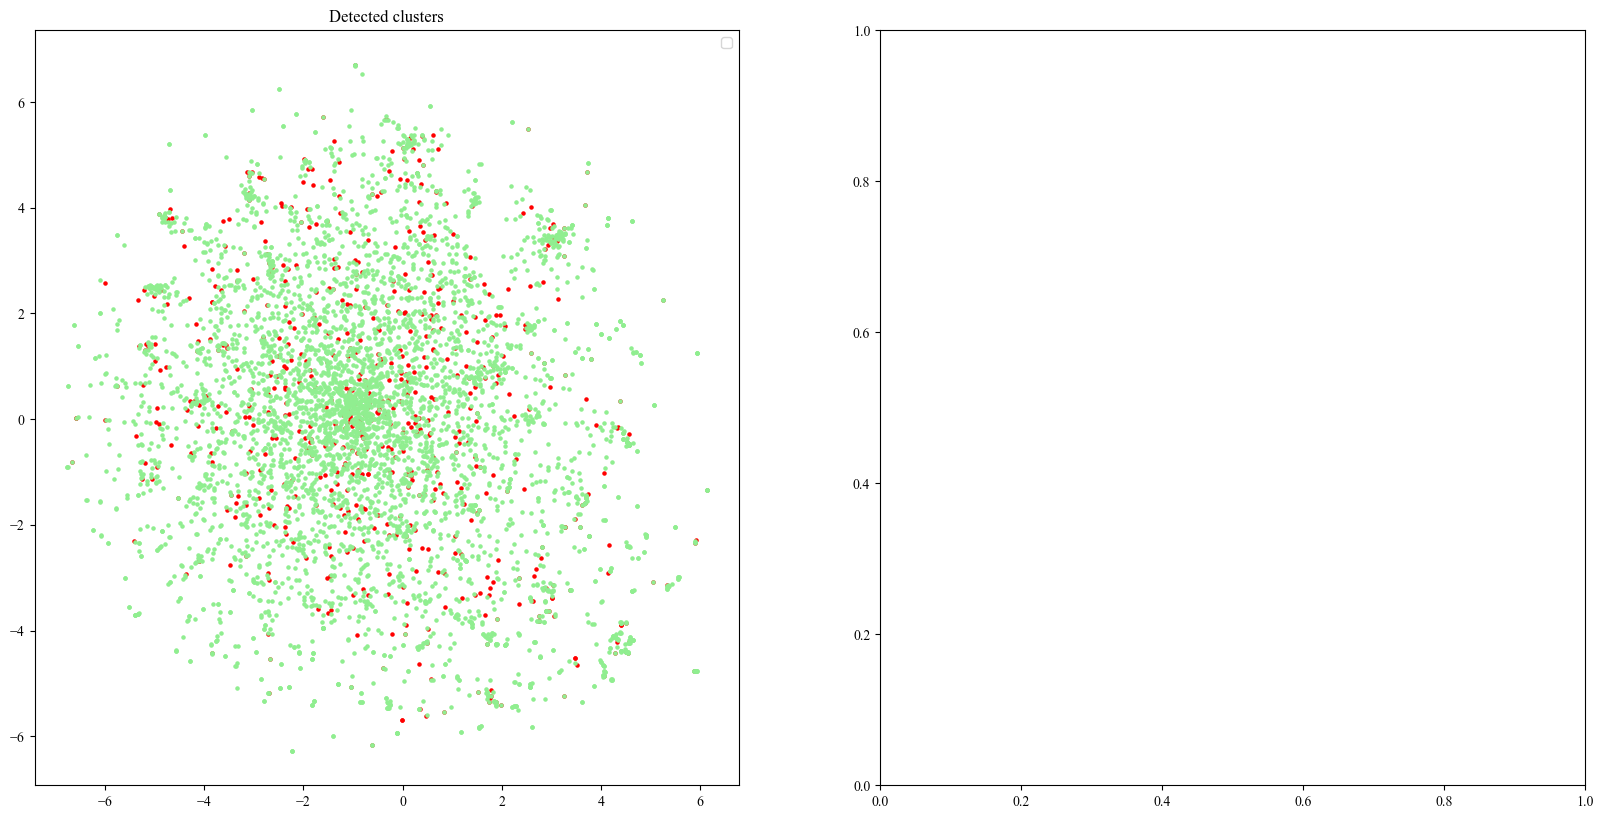

In [333]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)

clust_1 = np.where(assign==0)
clust_2 = np.where(assign==1)

ax1.scatter(X_tsne.T[0,:][clust_1], X_tsne.T[1,:][clust_1], c='red',s=5)
ax1.scatter(X_tsne.T[0,:][clust_2], X_tsne.T[1,:][clust_2], c='lightgreen',s=5)
#ax1.scatter(centroids[0,0], centroids[0,1],s=50,marker='*', c='darkkhaki', label='Centroid 1')
#ax1.scatter(centroids[1,0], centroids[1,1],s=50,marker='*', c='darkolivegreen', label='Centroid 2')
ax1.set_title('Detected clusters')
ax1.legend()
plt.show()

This yielded only a marginal gain. Let us visualise the assigned clusters:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


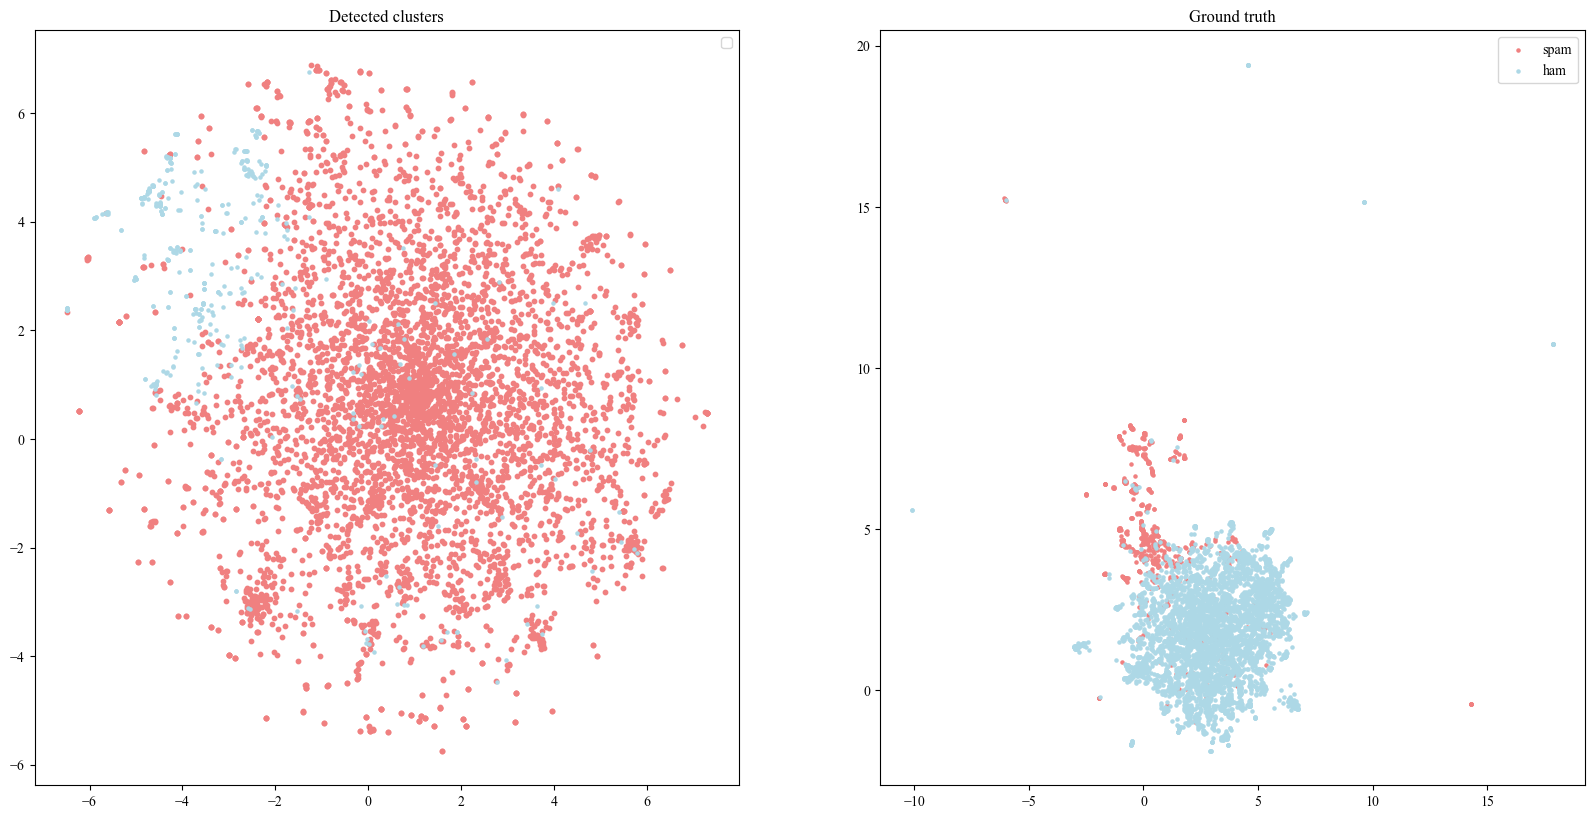

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)

clust_1 = np.where(assign==0)
clust_2 = np.where(assign==1)

ax1.scatter(X_tsne.T[0,:][clust_1], X_tsne.T[1,:][clust_1], c='lightcoral',s=10)
ax1.scatter(X_tsne.T[0,:][clust_2], X_tsne.T[1,:][clust_2], c='lightblue',s=5)
#ax1.scatter(centroids[0,0], centroids[0,1],s=50,marker='*', c='darkkhaki', label='Centroid 1')
#ax1.scatter(centroids[1,0], centroids[1,1],s=50,marker='*', c='darkolivegreen', label='Centroid 2')
ax1.set_title('Detected clusters')
ax1.legend()

ax2.scatter(X_umap.T[0,:][spam_idx], X_umap.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax2.scatter(X_umap.T[0,:][ham_idx], X_umap.T[1,:][ham_idx], c='lightblue',s=5, label='ham')
ax2.set_title('Ground truth')
ax2.legend()

plt.show()

# LSA (Different approach given PCA performed poorly

In [183]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=1000), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f'Explained variance: {explained_variance}')

Explained variance: 0.782957203832687


In [184]:
X_lsa.shape

(5572, 1000)

In [185]:
assign, centroids = kmeans(X_lsa, k=2, random_state=42, tot=1e-4, n_init=10)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 1.9612777355464122
Iteration number: 3 - diff 0.08291504405208328
Iteration number: 4 - diff 0.06187641773277943
Iteration number: 5 - diff 0.04740061087803264
Iteration number: 6 - diff 0.040499486676537994
Iteration number: 7 - diff 0.028865958956837842
Iteration number: 8 - diff 0.029811879998605934
Iteration number: 9 - diff 0.041395297140656144
Iteration number: 10 - diff 0.046045528870749704
Iteration number: 11 - diff 0.02682022408794052
Iteration number: 12 - diff 0.022499687978661413
Iteration number: 13 - diff 0.020574288907474023
Iteration number: 14 - diff 0.011784159597060613
Iteration number: 15 - diff 0.014382505980610801
Iteration number: 16 - diff 0.015338081603920573
Iteration number: 17 - diff 0.013292526394441615
Iteration number: 18 - diff 0.02087147847874243
Iteration number: 19 - diff 0.03547738000758446
Iteration number: 20 - diff 0.003199123091777306
C

Iteration number: 10 - diff 0.025686757711493813
Iteration number: 11 - diff 0.0324467495851337
Iteration number: 12 - diff 0.04035868741901336
Iteration number: 13 - diff 0.039848836124375606
Iteration number: 14 - diff 0.02893281528514266
Iteration number: 15 - diff 0.032727438388251415
Iteration number: 16 - diff 0.039779513786284394
Iteration number: 17 - diff 0.032812064727485976
Iteration number: 18 - diff 0.019405480626308057
Iteration number: 19 - diff 0.00990904102685954
Iteration number: 20 - diff 0.005670587945847143
Iteration number: 21 - diff 0.004040308276253736
Iteration number: 22 - diff 0.0028138383016751366
Iteration number: 23 - diff 0.0028713632674064833
Iteration number: 24 - diff 0.0014985935986156478


In [186]:
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)), assign))

0.3685206391955968


In [187]:
original_space_centroids = lsa[0].inverse_transform(centroids)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
true_k = 2

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: go come ur like u gt send love get think 
Cluster 1: call later prize sorri claim free urgent pleas mobil award 


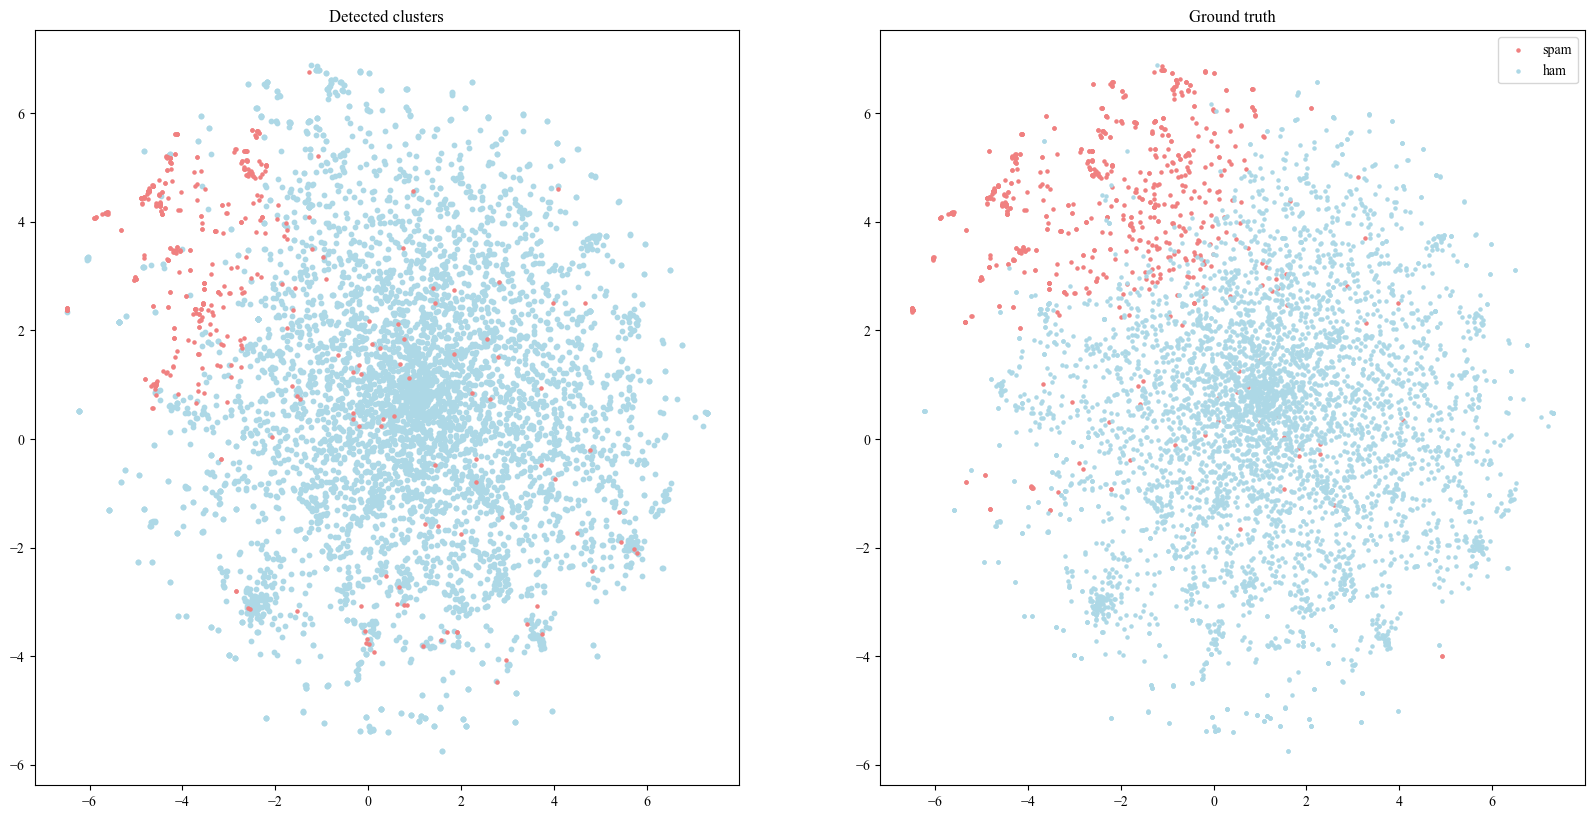

In [188]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)

clust_1 = np.where(assign==0)
clust_2 = np.where(assign==1)

ax1.scatter(X_tsne.T[0,:][clust_1], X_tsne.T[1,:][clust_1], c='lightblue',s=10)
ax1.scatter(X_tsne.T[0,:][clust_2], X_tsne.T[1,:][clust_2], c='lightcoral',s=5)
ax1.set_title('Detected clusters')

ax2.scatter(X_tsne.T[0,:][spam_idx], X_tsne.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax2.scatter(X_tsne.T[0,:][ham_idx], X_tsne.T[1,:][ham_idx], c='lightblue',s=5, label='ham')
ax2.set_title('Ground truth')
ax2.legend()

plt.show()

In [ ]:
#Nakis:

counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)
ax = plt.gca()


for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=1)
    ax.add_line(line)



for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=1)
    ax.add_line(line)

idx=y.argsort()
plt.spy(A_F[:,idx][idx,:],markersize=0.5)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

X_umap_dt = umap.UMAP(metric='cosine', n_components=10).fit_transform(X)

#UMAP unfortunately produces a few NaN values
NaN_idx = np.argwhere(np.isnan(X_umap_dt))
X_temp_dt = X_umap_dt[~np.isnan(X_umap_dt).any(axis=1)]
kmeans_assign, centroids = kmeans(X_temp_dt, k=2, random_state=2, tot=1e-4)

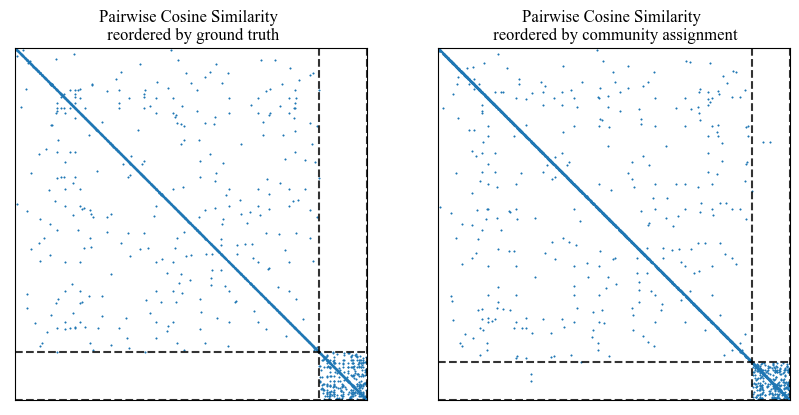

In [157]:
label = df['label'].replace({'ham':0, 'spam':1}).values[~np.isnan(X_umap_dt).any(axis=1)]
new_order = label.argsort()

_, group_len = np.unique(label, return_counts=True)

sim_matrix = cosine_similarity(X[~np.isnan(X_umap_dt).any(axis=1)], X[~np.isnan(X_umap_dt).any(axis=1)])
D = sim_matrix[:, new_order][new_order]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10), dpi=100)
ax1.spy(D, precision=1, markersize=0.5)
#ax1.spy(D[:group_len[0], :group_len[0]], color='blue')
#ax1.spy(D[group_len[1]:, group_len[1]:], color='red')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Pairwise Cosine Similarity \n reordered by ground truth")

###From Nakis:
y = label
N = X[~np.isnan(X_umap_dt).any(axis=1)].shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, linestyle='dashed', color='k', alpha=0.8)
    ax1.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, linestyle='dashed', color='k', alpha=0.8)
    ax1.add_line(line)
###


#sim_matrix = X.T@X
new_order = kmeans_assign.argsort()
sim_matrix = cosine_similarity(X[~np.isnan(X_umap_dt).any(axis=1)], X[~np.isnan(X_umap_dt).any(axis=1)])

D = sim_matrix[:, new_order][new_order]

#cmap = {0:'red', 1:'blue'}
#c=[cmap[i] for i in label]

ax2.spy(D, precision=1, markersize=0.5)
ax2.set_xticks([])
ax2.set_yticks([])

y = kmeans_assign
N = X[~np.isnan(X_umap_dt).any(axis=1)].shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, linestyle='dashed', color='k', alpha=0.8)
    ax2.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, linestyle='dashed', color='k', alpha=0.8)
    ax2.add_line(line)

ax2.set_title("Pairwise Cosine Similarity \n reordered by community assignment")
plt.savefig('sim_matrix.png')
plt.show()




# Results

## Reduced Dimensionality

In [67]:
from sklearn.cluster import DBSCAN, KMeans

X_umap_dt = umap.UMAP(metric='cosine', n_components=10, random_state=42).fit_transform(X)

#UMAP unfortunately produces a few NaN values
NaN_idx = np.argwhere(np.isnan(X_umap_dt))
X_temp_dt = X_umap_dt[~np.isnan(X_umap_dt).any(axis=1)]
kmeans_assign, centroids = kmeans(X_temp_dt, k=2, random_state=2, tot=1e-4)

label = df['label'].replace({'ham':0, 'spam':1}).values[~np.isnan(X_umap_dt).any(axis=1)]

clustering_db = DBSCAN(eps=1, min_samples=20).fit(X_temp_dt)
dbscan_assign = clustering_db.labels_

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2212 edges.
It has only fully disconnected 88 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 10.927327139506062
Iteration number: 3 - diff 1.1186288130013715
Current best inertia: 27305.745678260027
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.7601446035595316
Iteration number: 3 - diff 0.5796408682023798
Iteration number: 4 - diff 0.5323738867314616
Iteration number: 5 - diff 0.1506719000363242
Iteration number: 6 - diff 0.03425879232942049
Iteration number: 7 - diff 0.016744086190362426
Current best inertia: 21533.033106836683
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.2919349014136063
Iteration number: 3 - diff 0.7128321412140997
Iteration number: 4 - diff 0.3659033004206027
Iteration number: 5 - diff 0.34211265868561697
Iteration number: 6 - diff 0.38552739168635597
Iteration number: 7 - diff 0.5507280826419584
Iteration number:

In [68]:
from sklearn import metrics

def performance_metrics(X, assign, labels):
    print(f'ARI: {metrics.adjusted_rand_score(labels, assign):.3f}')
    print(f'NMI: {metrics.adjusted_mutual_info_score(labels, assign):.3f}')
    print(f'DBI: {metrics.davies_bouldin_score(X, assign):.3f}')
    print('\n')
    return None

In [69]:
performance_metrics(X_temp_dt, kmeans_assign, label)
performance_metrics(X_temp_dt, dbscan_assign, label)

ARI: 0.764
NMI: 0.592
DBI: 1.019


ARI: -0.000
NMI: 0.009
DBI: 1.742




In [160]:
#assign_kmeans, centroids_kmeans = kmeans(X.toarray(), k=2, random_state=2, tot=0.0001)
#clustering_db = DBSCAN(eps=1, min_samples=20).fit(X)
#dbscan_assign = clustering_db.labels_

#label = df['label'].replace({'ham':0, 'spam':1})

#performance_metrics(X.toarray(), kmeans_assign, label)
#performance_metrics(X.toarray(), dbscan_assign, label)

## Converting high dim space to distance

In [95]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.cluster import DBSCAN, KMeans
dist = pairwise_distances(vecs, metric='cosine')

assign_kmeans, centroids_kmeans = kmeans(dist, k=2, random_state=2, tot=0.0001, n_init=1)

Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 5.306247197225021
Iteration number: 3 - diff 0.14378243238283492
Current best inertia: 43062.82902512172


In [98]:
dist = pairwise_distances(vecs, metric='cosine')
clustering_db = DBSCAN(eps=0.1, min_samples=2, metric='precomputed').fit(dist)
dbscan_assign = clustering_db.labels_

In [106]:
dist = pairwise_distances(vecs, metric='cosine')
clustering_km = KMeans(n_clusters=2).fit(dist)
kmeans_assign = clustering_km.labels_

In [107]:
label = df['label'].replace({'ham':0, 'spam':1})
performance_metrics(X.toarray(), kmeans_assign, label)
performance_metrics(X.toarray(), dbscan_assign, label)

ARI: 0.340
NMI: 0.165
DBI: 6.426


ARI: 0.339
NMI: 0.163
DBI: 6.487




# Analysing content of clusters 
The following section will analyse the content of the best obtained clusters (Kmeans+UMAP). We will also take an extra look at the sms that have been wrongly classified.


In [161]:
X_umap_dt = umap.UMAP(metric='cosine', n_components=10, random_state=42).fit_transform(X)

#UMAP unfortunately produces a few NaN values
NaN_idx = np.argwhere(np.isnan(X_umap_dt))
X_temp_dt = X_umap_dt[~np.isnan(X_umap_dt).any(axis=1)]
kmeans_assign, centroids = kmeans(X_temp_dt, k=2, random_state=2, tot=1e-4)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 2212 edges.
It has only fully disconnected 88 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


Kmeans run no. 1
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 10.927327139506062
Iteration number: 3 - diff 1.1186288130013715
Current best inertia: 27305.745678260027
Kmeans run no. 2
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.7601446035595316
Iteration number: 3 - diff 0.5796408682023798
Iteration number: 4 - diff 0.5323738867314616
Iteration number: 5 - diff 0.1506719000363242
Iteration number: 6 - diff 0.03425879232942049
Iteration number: 7 - diff 0.016744086190362426
Current best inertia: 21533.033106836683
Kmeans run no. 3
Number of centroids defined: 2
Iteration number: 1 - diff 100000.0
Iteration number: 2 - diff 2.2919349014136063
Iteration number: 3 - diff 0.7128321412140997
Iteration number: 4 - diff 0.3659033004206027
Iteration number: 5 - diff 0.34211265868561697
Iteration number: 6 - diff 0.38552739168635597
Iteration number: 7 - diff 0.5507280826419584
Iteration number:

In [163]:
clust1 = np.where(kmeans_assign==0)[0]
clust2 = np.where(kmeans_assign==1)[0]

In [188]:
NaN_idx.shape

(880, 2)

In [189]:
from wordcloud import WordCloud

temp_TDM = TDM.drop(NaN_idx[:,0])

clust1_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(temp_TDM.iloc[clust1].T.sum(axis=1))
clust2_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(temp_TDM.iloc[clust2].T.sum(axis=1))


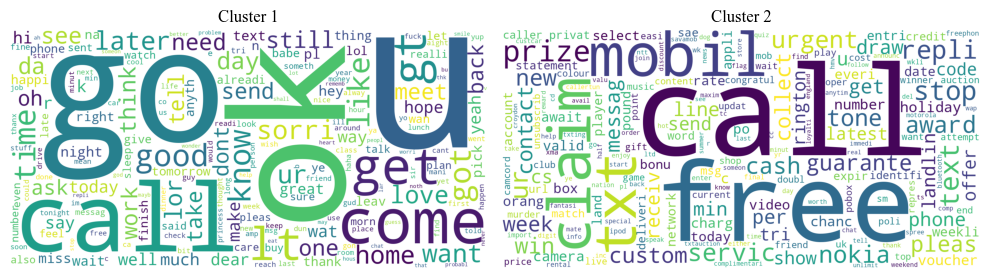

In [199]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), dpi=100)
ax1.imshow(clust1_cloud)
ax1.axis("off")
ax1.set_title('Cluster 1')

ax2.imshow(clust2_cloud)
ax2.axis("off")
ax2.set_title('Cluster 2')
fig.tight_layout()
plt.show()

## Investigation of wrongly classified SMS

In [207]:
label = df['label'].replace({'ham':0, 'spam':1}).values[~np.isnan(X_umap_dt).any(axis=1)]
mismatch = np.where((label-kmeans_assign) != 0)

In [210]:
mismatch[0].shape

(236,)

There is 236 wrongly classified documents.

# Analyse the centroids

# Kladde

In [454]:
from sklearn.cluster import DBSCAN

In [455]:
clustering = DBSCAN(eps=1, min_samples=20).fit(X_temp)
assign = clustering.labels_
np.unique(assign, return_counts=True)

(array([-1,  0,  1]), array([  37, 5477,   21]))

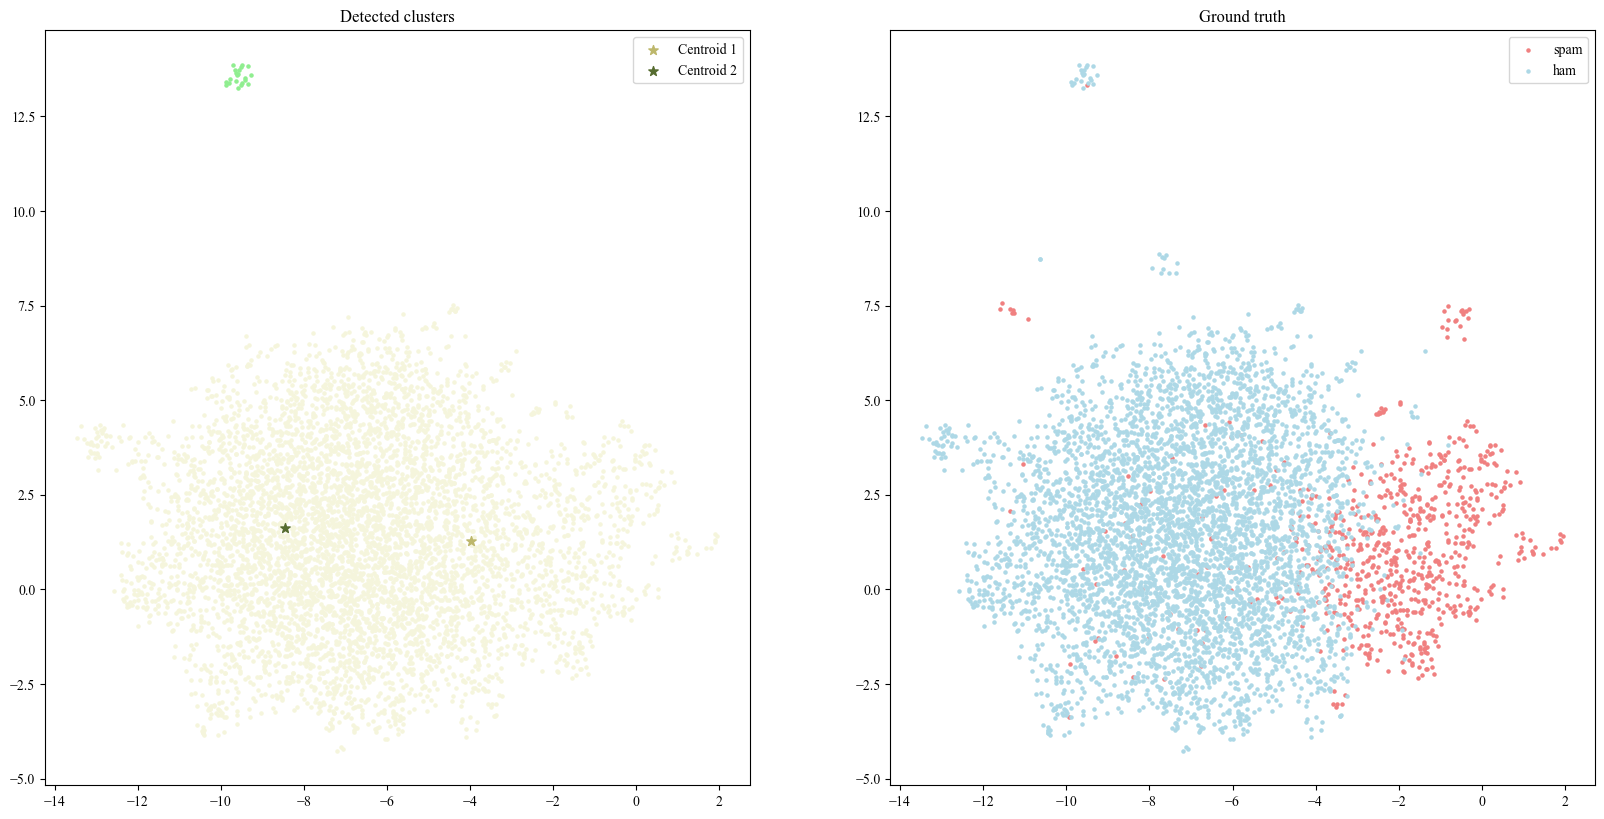

In [457]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10), dpi=100)

clust_1 = np.where(assign==0)
clust_2 = np.where(assign==1)

ax1.scatter(X_temp.T[0,:][clust_1], X_temp.T[1,:][clust_1], c='beige',s=5)
ax1.scatter(X_temp.T[0,:][clust_2], X_temp.T[1,:][clust_2], c='lightgreen',s=5)
ax1.scatter(centroids[0,0], centroids[0,1],s=50,marker='*', c='darkkhaki', label='Centroid 1')
ax1.scatter(centroids[1,0], centroids[1,1],s=50,marker='*', c='darkolivegreen', label='Centroid 2')
ax1.set_title('Detected clusters')
ax1.legend()

ax2.scatter(X_umap.T[0,:][spam_idx], X_umap.T[1,:][spam_idx], c='lightcoral',s=5, label='spam')
ax2.scatter(X_umap.T[0,:][ham_idx], X_umap.T[1,:][ham_idx], c='lightblue',s=5, label='ham')
ax2.set_title('Ground truth')
ax2.legend()

plt.show()

In [459]:
print(adjusted_rand_score(df.label.map(dict(spam=1, ham=0)).drop(np.unique(NaN_idx[:,0])), assign))

0.0368222704780176


# Resources
Choosing UMAP components https://stackoverflow.com/questions/63139766/how-to-choose-the-right-number-of-dimension-in-umap